In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler

tfk = tf.keras
tfkl = tf.keras.layers

2025-07-21 10:03:56.293108: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 10:03:56.297734: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 10:03:56.337160: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 10:03:56.372129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753081436.405520   42875 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753081436.41

In [98]:
import re
import string

def shannon_entropy(text):
    text = re.sub(r'[^a-zA-Z]', '', text).lower()
    n = len(text)
    if n == 0:
        return 0, {f"freq_{l}": 0 for l in string.ascii_lowercase}

    freq = {f"freq_{l}": text.count(l) for l in string.ascii_lowercase}
#     print(freq)
#     print("\n\n\n\n")
    entropy = -sum(
        (count / n) * math.log2(count / n)
        for count in freq.values() if count > 0
    )
    entropy = round(entropy, 5)
    return entropy, freq

text = "test asta este un test"
shannon_entropy(text)

(2.30827,
 {'freq_a': 2,
  'freq_b': 0,
  'freq_c': 0,
  'freq_d': 0,
  'freq_e': 4,
  'freq_f': 0,
  'freq_g': 0,
  'freq_h': 0,
  'freq_i': 0,
  'freq_j': 0,
  'freq_k': 0,
  'freq_l': 0,
  'freq_m': 0,
  'freq_n': 1,
  'freq_o': 0,
  'freq_p': 0,
  'freq_q': 0,
  'freq_r': 0,
  'freq_s': 4,
  'freq_t': 6,
  'freq_u': 1,
  'freq_v': 0,
  'freq_w': 0,
  'freq_x': 0,
  'freq_y': 0,
  'freq_z': 0})

In [99]:
import csv
import string
language_folders = ['texts_english', 'texts_french', 'texts_polish']
field_names = ["entropy"] + [f"freq_{l}" for l in string.ascii_lowercase] + ["lang"]

with open("languages.csv", "w", newline='', encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = field_names)
    writer.writeheader()
    
    for folder in language_folders:
        folder_path = os.path.join('texts', folder)
        for filename in os.listdir(os.path.join('texts', folder)):
            file_path = os.path.join(folder_path, filename)
        
            if filename.endswith(".txt") and os.path.isfile(file_path):
                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.read()
                    entropy, freq = shannon_entropy(content)
                    file_path.split('/')[1].split('_')[1]
                    row = {
                        "entropy": entropy,
                        **freq,
                        "lang": file_path.split('/')[1].split('_')[1]
                    }
                    writer.writerow(row)

In [100]:
data = pd.read_csv("languages.csv", delimiter=',')
data.head()

,entropy,freq_a,freq_b,freq_c,freq_d,freq_e,freq_f,freq_g,freq_h,freq_i,...,freq_r,freq_s,freq_t,freq_u,freq_v,freq_w,freq_x,freq_y,freq_z,lang
0,4.16015,372,64,138,229,592,110,85,275,307,...,413,312,435,110,65,84,15,92,6,english
1,4.19318,353,76,163,114,457,85,74,143,353,...,213,280,266,126,52,51,21,60,13,english
2,4.15868,343,108,121,178,572,110,100,249,378,...,339,304,362,96,39,89,6,81,8,english
3,4.16598,429,105,201,193,561,116,90,265,400,...,259,324,401,133,33,81,8,82,9,english
4,4.18115,309,83,114,154,484,74,86,222,278,...,268,269,318,82,31,44,5,80,24,english


In [101]:
df_model = data.copy()

y_data = df_model['lang'].values

y_data = pd.get_dummies(y_data, columns=["lang"])

features = ['entropy'] + [f"freq_{l}" for l in string.ascii_lowercase]

X_df = df_model[features]

In [102]:
scaler_x = RobustScaler()
x_features = scaler_x.fit_transform(X_df)
y_target = y_data

In [103]:
print(x_features.shape)
print(y_target.shape)

(30, 27)
(30, 3)


In [104]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=45, stratify=y_target)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=45, stratify=y_train)

In [134]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(19, 27)
(19, 3)
(6, 27)
(6, 3)
(5, 27)
(5, 3)


In [110]:
from tensorflow.keras.layers import LeakyReLU

input_dim = x_features.shape[1]
model = tfk.Sequential([
    tfkl.InputLayer(shape=(input_dim,)),
    tfkl.Dense(256,LeakyReLU(negative_slope = 0.00001), name="Hidden_Layer_1"),
    tfkl.Dense(256,LeakyReLU(negative_slope = 0.00001), name="Hidden_Layer_2"),
    tfkl.Dense(3, activation='softmax', name="Output_Layer")
])

In [111]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

epochs = 100
batch_size = 4
opt = tfk.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks = [early_stop]
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 256)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,731 (288.01 KB)

 Trainable params: 73,731 (288.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3692 - loss: 0.7058 - val_accuracy: 0.2000 - val_loss: 0.7236
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2407 - loss: 0.7178 - val_accuracy: 0.2000 - val_loss: 0.7192
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4247 - loss: 0.6839 - val_accuracy: 0.2000 - val_loss: 0.7148
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4803 - loss: 0.6705 - val_accuracy: 0.2000 - val_loss: 0.7103
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4388 - loss: 0.6764 - val_accuracy: 0.2000 - val_loss: 0.7059
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3971 - loss: 0.6713 - val_accuracy: 0.2000 - val_loss: 0.7016
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4249 - loss: 0.6640 - val_accuracy: 0.2000 - val_loss: 0.6974
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4214 - loss: 0.6589 - val_accuracy: 0.2000 - val_loss: 0.69

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.4799 - val_accuracy: 1.0000 - val_loss: 0.5391
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.4655 - val_accuracy: 1.0000 - val_loss: 0.5360
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.4892 - val_accuracy: 1.0000 - val_loss: 0.5327
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.4521 - val_accuracy: 1.0000 - val_loss: 0.5297
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.4381 - val_accuracy: 1.0000 - val_loss: 0.5268
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.4580 - val_accuracy: 1.0000 - val_loss: 0.5237
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.4529 - val_accuracy: 1.0000 - val_loss: 0.5207
Epoch 59/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.4381 - val_accuracy: 1.0000 - val_loss: 0.5177
Epoch

In [112]:
y_pread = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


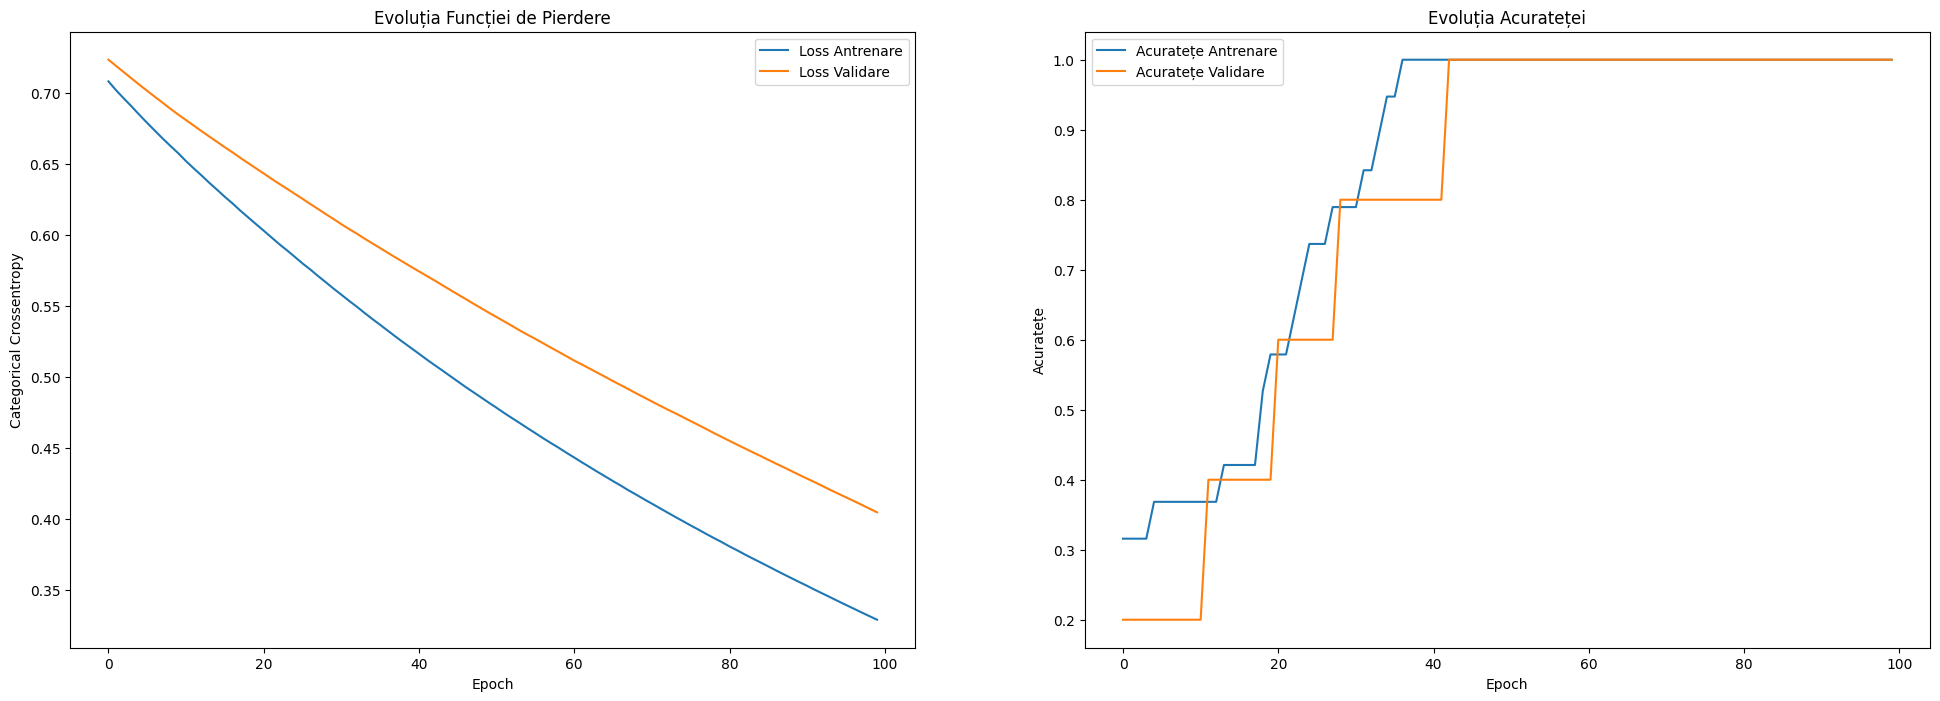

[2 0 1 0 2 1]

--- RAPORT DE PERFORMANȚĂ PE SETUL DE TEST ---

Acuratețea: 100.00%

Raport de Clasificare:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00         2
      French       1.00      1.00      1.00         2
      Polish       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



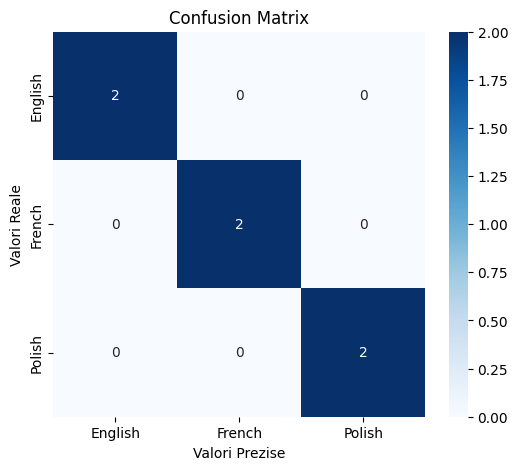

In [130]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

def evalueaza_model_multiclasa(y_test, y_pred_proba, history, class_names):
    # Grafice antrenare
    plt.rcParams["figure.figsize"] = (24, 8)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Loss Antrenare")
    plt.plot(history.history['val_loss'], label="Loss Validare")
    plt.title('Evoluția Funcției de Pierdere')
    plt.xlabel('Epoch')
    plt.ylabel('Categorical Crossentropy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label="Acuratețe Antrenare")
    plt.plot(history.history['val_accuracy'], label="Acuratețe Validare")
    plt.title('Evoluția Acurateței')
    plt.xlabel('Epoch')
    plt.ylabel('Acuratețe')
    plt.legend()
    plt.show()

    # Predictii finale
    y_pred_clasa = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\n--- RAPORT DE PERFORMANȚĂ PE SETUL DE TEST ---\n")
    acuratete = accuracy_score(y_true, y_pred_clasa)
    print(f"Acuratețea: {acuratete:.2%}")
    print("\nRaport de Clasificare:")
    print(classification_report(y_true, y_pred_clasa, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_clasa)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Valori Prezise')
    plt.ylabel('Valori Reale')
    plt.title('Confusion Matrix')
    plt.show()

y_pred_proba = model.predict(x_test)

evalueaza_model_multiclasa(y_test, y_pred_proba, history, class_names=['English', 'French', 'Polish'])

In [148]:
class_names = ["English", "French", "Polish"]
entropy, freq = shannon_entropy("Cześć, nazywam się Anna. Mieszkam w Warszawie i lubię książki. Dzisiaj jest słoneczny dzień. Idziemy do parku. Lubię jabłka, gruszki i truskawki. To moje ulubione owoce.")

freq = list(freq.values())
test_input = np.array([[entropy] + freq])
print(test_input.shape)

print(model.predict(test_input))
print(np.argmax(model.predict(test_input), axis=1))

(1, 27)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.2900934  0.00777079 0.70213586]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[2]
